In [2]:
import gymnasium as gym
from gymnasium import spaces

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [5]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 19:50:00+00:00,385.609985,385.769989,384.399994,384.500000,148931,385.301743,385.236278,33.421441,-0.182363,-0.095691,385.451317,386.123788,384.778845,385.317351,384.657353,384.934110,385.381472
2025-04-15 19:52:00+00:00,385.700012,386.000000,385.500000,385.560913,94713,385.345990,385.333317,50.873477,-0.130202,-0.102593,385.463477,386.150336,384.776617,385.283011,384.657353,384.934110,385.381472
2025-04-15 19:54:00+00:00,385.984985,386.070007,385.369995,385.670013,202505,385.438489,385.454532,53.987373,-0.069502,-0.095975,385.481976,386.206613,384.757340,385.335147,384.657353,384.934110,385.381472


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

## Step is to trade one stock at a time

In [8]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=10, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock  # NEW

        self.context_width = context_width
        self.offset = offset
        self.num_features = df.shape[1]

        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock  # NEW

        if seed is not None:
            np.random.seed(seed)

        obs = self._get_obs()
        info = {}
        return obs, info

    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data reached. No further rendering possible.")
            return

        price = self.df.iloc[self.current_step]["Close"]
        net_worth = self.cash + self.stock_held * price
        profit_loss = net_worth - (self.initial_cash + self.initial_stock * price)
        status = "PROFIT" if profit_loss > 0 else "LOSS" if profit_loss < 0 else "BREAKEVEN"

        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, "
              f"Net Worth: {net_worth:.2f}, P/L: {profit_loss:.2f} ({status})")



    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs  # 2D now: [context_width x (features + 2)]

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
    
        current_price = self.df.iloc[self.current_step]["Close"]
        prev_total_asset = self.cash + self.stock_held * current_price
    
        # --- Execute Action ---
        if action == 1 and self.cash >= current_price:  # Buy
            self.cash -= current_price
            self.stock_held += 1
        elif action == 2 and self.stock_held > 0:       # Sell
            self.cash += current_price
            self.stock_held -= 1
        # else: HOLD → no action taken
    
        self.current_step += 1
    
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1
        # Reward Logic
        next_price = self.df.iloc[self.current_step]["Close"] if self.current_step < len(self.df) else current_price
        current_total_asset = self.cash + self.stock_held * next_price
    
        reward = current_total_asset - prev_total_asset
    
        # Optionally add HOLD-specific logic
        if action == 0:  # HOLD
            price_change = next_price - current_price
            if self.stock_held > 0:
                reward += price_change  # Reward holding if price is going up
            else:
                reward -= abs(price_change) * 0.1  # Small penalty for holding when not invested
    
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info


In [9]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch
import torch.nn as nn

class CNNLSTMFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128, lstm_hidden_size=64):
        super().__init__(observation_space, features_dim)
        self.context_width, self.input_dim = observation_space.shape  # (time, features)

        # CNN part
        self.conv1 = nn.Conv1d(in_channels=self.input_dim, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # LSTM part
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, batch_first=True)

        # Linear projection to final features
        self.linear = nn.Sequential(
            nn.Linear(lstm_hidden_size, features_dim),
            nn.ReLU()
        )

    def forward(self, obs):
        # obs: (batch, context_width, input_dim)
        x = obs.permute(0, 2, 1)  # → (batch, input_dim, context_width)

        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))  # → (batch, 64, context_width)

        x = x.permute(0, 2, 1)  # → (batch, context_width, 64)
        _, (hn, _) = self.lstm(x)  # hn: (1, batch, hidden_size)

        x = hn.squeeze(0)  # → (batch, hidden_size)
        return self.linear(x)  # → (batch, features_dim)


In [11]:
# !pip install Shimmy

In [12]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import DummyVecEnv

In [18]:
# ----------- Training -------------
context_width = 20
offset = 1

split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

train_env = DummyVecEnv([lambda: TradingEnv(train_df, context_width=context_width, offset=offset)])

policy_kwargs = dict(
    features_extractor_class=CNNLSTMFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128, lstm_hidden_size=64)
)

steps_per_episode = len(train_df) - context_width
total_timesteps = 100 * steps_per_episode

model = DQN("MlpPolicy", train_env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=total_timesteps)

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 269      |
|    time_elapsed     | 64       |
|    total_timesteps  | 17276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 4293     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 242      |
|    time_elapsed     | 142      |
|    total_timesteps  | 34552    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 8612     |
----------------------------------
----------------------------------
| rollout/            |          |
| 

Step: 21, Cash: 615.88, Stock: 11, Net Worth: 4842.46, P/L: 0.11 (PROFIT)
Step: 22, Cash: 231.64, Stock: 12, Net Worth: 4839.04, P/L: -0.46 (LOSS)
Step: 23, Cash: 231.64, Stock: 12, Net Worth: 4840.60, P/L: -0.20 (LOSS)
Step: 24, Cash: 231.64, Stock: 12, Net Worth: 4841.33, P/L: -0.08 (LOSS)
Step: 25, Cash: 231.64, Stock: 12, Net Worth: 4841.35, P/L: -0.08 (LOSS)
Step: 26, Cash: 231.64, Stock: 12, Net Worth: 4840.36, P/L: -0.24 (LOSS)
Step: 27, Cash: 231.64, Stock: 12, Net Worth: 4842.04, P/L: 0.04 (PROFIT)
Step: 28, Cash: 231.64, Stock: 12, Net Worth: 4842.46, P/L: 0.11 (PROFIT)
Step: 29, Cash: 231.64, Stock: 12, Net Worth: 4846.96, P/L: 0.86 (PROFIT)
Step: 30, Cash: 231.64, Stock: 12, Net Worth: 4846.48, P/L: 0.78 (PROFIT)
Step: 31, Cash: 231.64, Stock: 12, Net Worth: 4846.18, P/L: 0.73 (PROFIT)
Step: 32, Cash: 231.64, Stock: 12, Net Worth: 4847.32, P/L: 0.92 (PROFIT)
Step: 33, Cash: 231.64, Stock: 12, Net Worth: 4849.84, P/L: 1.34 (PROFIT)
Step: 34, Cash: 231.64, Stock: 12, Net Wort

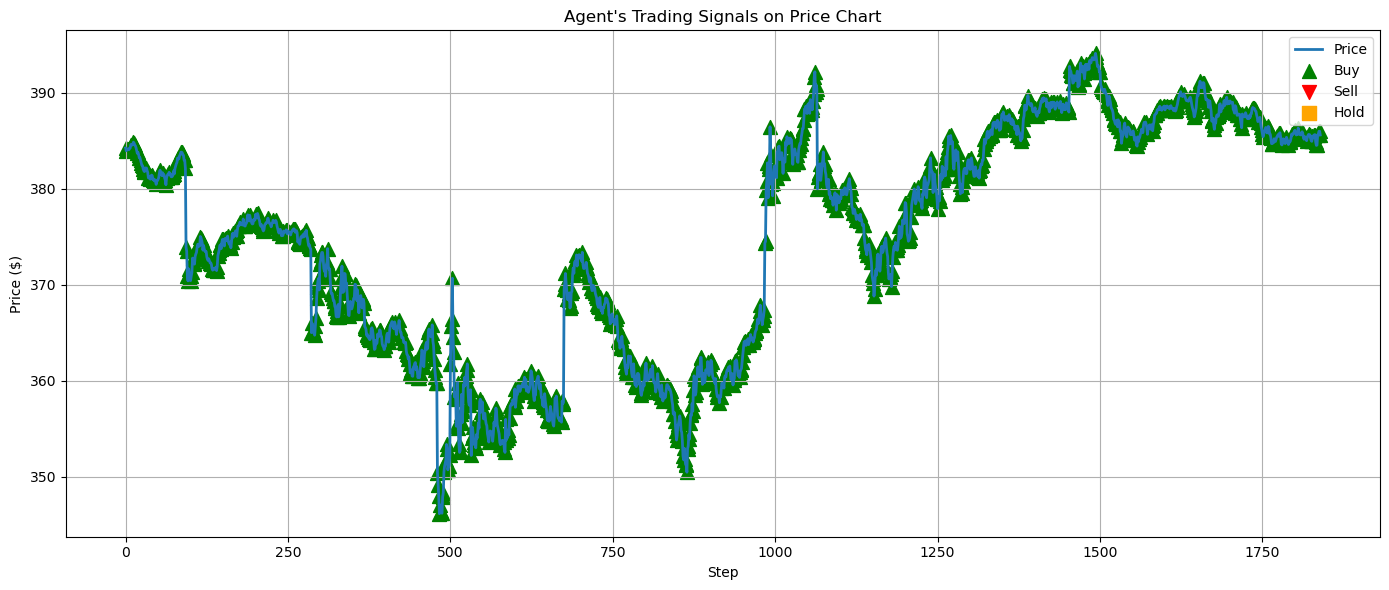

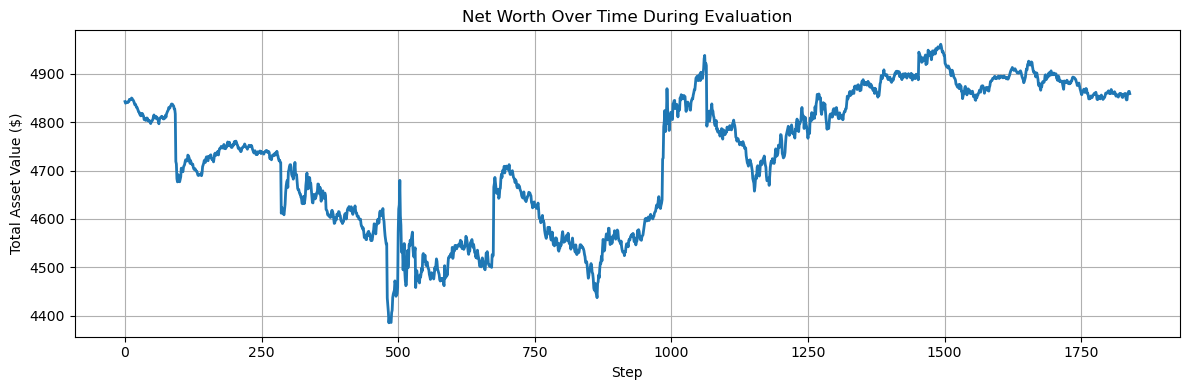

In [23]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df, context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


Step: 21, Cash: 615.88, Stock: 11, Net Worth: 4842.46, P/L: 0.11 (PROFIT)
Step: 22, Cash: 231.64, Stock: 12, Net Worth: 4839.04, P/L: -0.46 (LOSS)
Step: 23, Cash: 231.64, Stock: 12, Net Worth: 4840.60, P/L: -0.20 (LOSS)
Step: 24, Cash: 231.64, Stock: 12, Net Worth: 4841.33, P/L: -0.08 (LOSS)
Step: 25, Cash: 231.64, Stock: 12, Net Worth: 4841.35, P/L: -0.08 (LOSS)
Step: 26, Cash: 231.64, Stock: 12, Net Worth: 4840.36, P/L: -0.24 (LOSS)
Step: 27, Cash: 231.64, Stock: 12, Net Worth: 4842.04, P/L: 0.04 (PROFIT)
Step: 28, Cash: 231.64, Stock: 12, Net Worth: 4842.46, P/L: 0.11 (PROFIT)
Step: 29, Cash: 231.64, Stock: 12, Net Worth: 4846.96, P/L: 0.86 (PROFIT)
Step: 30, Cash: 231.64, Stock: 12, Net Worth: 4846.48, P/L: 0.78 (PROFIT)
Step: 31, Cash: 231.64, Stock: 12, Net Worth: 4846.18, P/L: 0.73 (PROFIT)
Step: 32, Cash: 231.64, Stock: 12, Net Worth: 4847.32, P/L: 0.92 (PROFIT)
Step: 33, Cash: 231.64, Stock: 12, Net Worth: 4849.84, P/L: 1.34 (PROFIT)
Step: 34, Cash: 231.64, Stock: 12, Net Wort

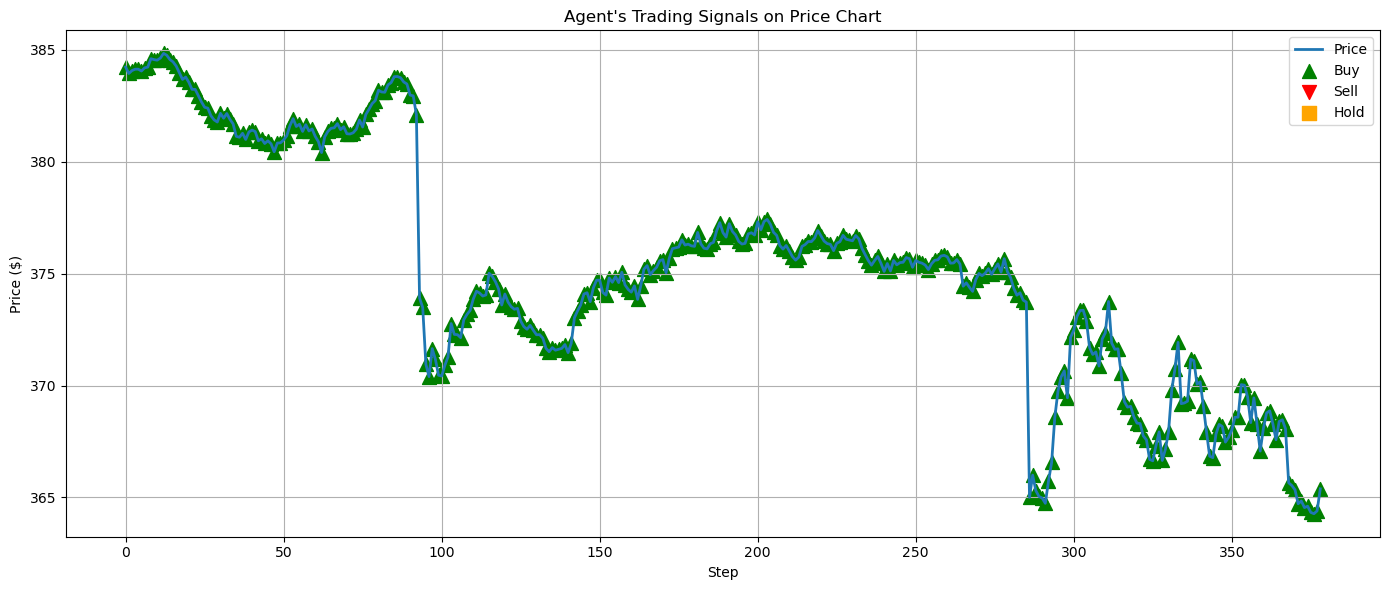

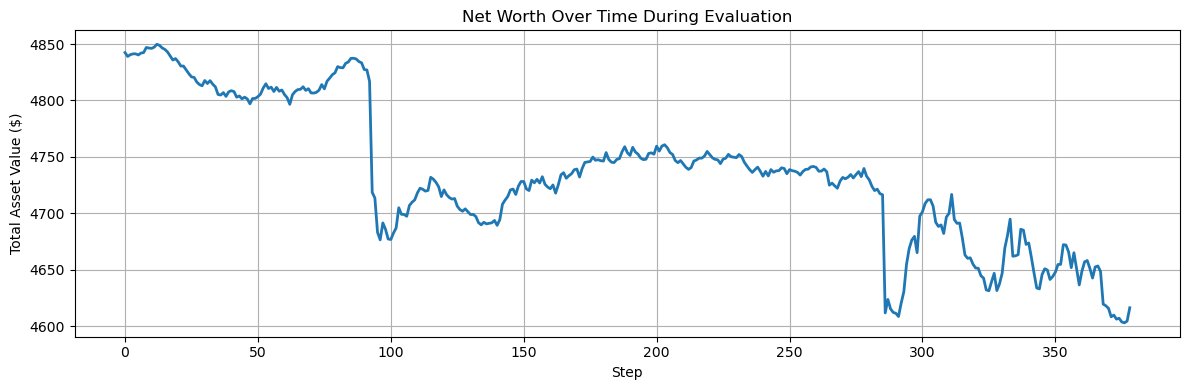

In [27]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df[:400], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df[100:300], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
